# Import libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 30)

# Read data

In [43]:
df = pd.read_csv("data/df_final.csv", index_col=0)
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,control_count,chapter_transfer,temp_date,chapter_size,chapter_retention_rate,chapter_growth_rate,industry,seat_popularity_rate,drop_date,final_palms_date,date_diff,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,9,0,2015-12-01,32,0.315789,1.421053,"Art, Art Framing and Products",0.076923,2016-09-14,2016-09-01,-13 days +00:00:00.000000000,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,9,0,2017-01-01,34,0.718750,1.093750,"Health & Wellness, Chiropractor",0.266667,NaN,2021-10-01,NaN,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,9,0,2018-01-01,21,0.424242,0.636364,"Health & Wellness, Chiropractor",0.210526,NaN,2021-10-01,NaN,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,9,0,2019-01-01,22,0.739130,1.217391,"Health & Wellness, Chiropractor",0.263158,NaN,2021-10-01,NaN,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,9,0,2020-01-01,26,0.760000,1.120000,"Health & Wellness, Chiropractor",0.277778,NaN,2021-10-01,NaN,0


In [44]:
df.shape

(2209, 29)

In [45]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'control_count', 'chapter_transfer', 'temp_date',
       'chapter_size', 'chapter_retention_rate', 'chapter_growth_rate',
       'industry', 'seat_popularity_rate', 'drop_date', 'final_palms_date',
       'date_diff', 'wont_renew'],
      dtype='object')

### Remove unnecessary columns
There are a couple of columns which are missing data: ```drop_date``` and ```date_diff```. There are also some columns which are left over after the data preparation phase and are unnecessary.

In [46]:
df.drop(["drop_date", "temp_date", "date_diff", "final_palms_date", "industry"], axis=1, inplace=True)

# Remove bad data
The following columns indicate member attendance rate:
- P - Present
- A - Abesent
- L - Late
- M - Medical
- S - Substitute

When those 5 columns are summed they will display a total number of meetings the member attended during the 9-month period. 

In [47]:
df["total_meetings"] = df["P"] + df["A"] + df["L"] + df["M"] + df["S"]

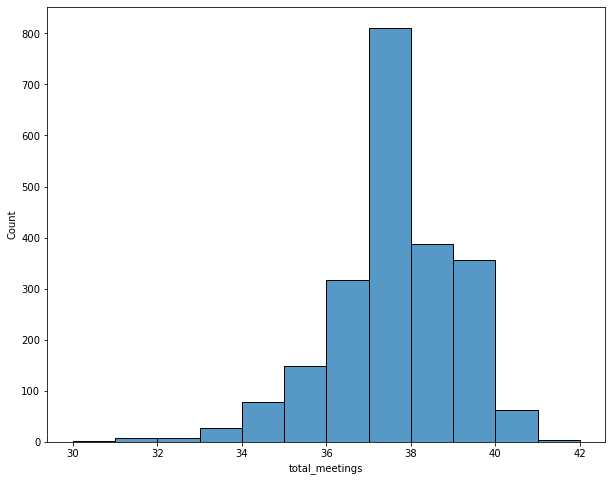

In [48]:
plt.figure(figsize=(10, 8))
sns.histplot(df["total_meetings"], binwidth=1)
plt.show()

In [49]:
df["total_meetings"].value_counts().sort_index()

30      2
31      8
32      7
33     27
34     79
35    148
36    317
37    811
38    388
39    357
40     62
41      2
42      1
Name: total_meetings, dtype: int64

It is impossible for there to be more than 40 weeks during 9-month period so such records can immediately be dropped.

In [50]:
df = df.loc[df["total_meetings"] <= 40]

In [51]:
df["total_meetings"].quantile(0.05)

34.0

Lets also examine further records which are below the 0.05 quantile - less than 34 meetings. Such records are possible as there are some holidays during the year but they are unlikely and should be examined further. This can be done in comination with an imported dataset ```df_pre_agg``` which will allow to examine the data before it was aggregated into 9-month form.

In [52]:
df_pre_agg = pd.read_csv("data/df_pre_aggregation.csv", index_col=0)
df_pre_agg.head()

,user_ID,chapter_ID,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,palms_date,relative_renewal_date
0,447,9,4,0,0,0,0,1,1,0,4,0,7,0,0,2015-01-01,2015-07-01
1,1366,9,4,0,0,0,0,4,0,0,2,0,7,4975,0,2015-01-01,2015-06-01
3,1035,9,4,0,0,0,0,0,7,0,4,0,6,500,0,2015-01-01,2015-05-01
4,3035,12,1,3,0,0,0,0,1,0,0,0,0,125,0,2015-01-01,2015-07-01
8,464,23,4,0,0,0,0,3,1,0,2,1,7,735,0,2015-01-01,2015-05-01


Lets also import ```df_database``` to see when a given member joined BNI.

In [53]:
df_database = pd.read_csv("data/database_data.csv", index_col=0, encoding="ISO-8859-1")
df_database["join_date"] = pd.to_datetime(df_database["join_date"], format='%m/%d/%Y', errors='coerce')
df_database["renewal_date"] = pd.to_datetime(df_database["renewal_date"], format='%m/%d/%Y', errors='coerce')
df_database.drop(["industry", "sponsor_ID"], axis=1, inplace=True)
df_database.head()

,user_ID,chapter_ID,join_date,renewal_date
0,1034,23,2004-07-01,2010-12-01
1,909,23,2008-02-01,2008-12-01
2,2062,23,2010-09-01,2011-12-01
3,947,23,2007-03-01,2008-04-07
4,2311,23,2007-07-01,2008-07-01


The below code is used to examine records in ```df``` with less than 34 meetings. Such records will be looked up in the ```df_pre_agg``` and if there are too few meetings compared to how many meetings there should be in that 9-month period (compared to members from the same chapter and same ```relative_renewal_date```) - the record will be dropped

In [68]:
# Records to check
df.loc[df["total_meetings"] < 34, :].shape[0]

44

## Start checking process

In [253]:
# Iterate over "index" to check each record
index = 43
extra_columns = ["RGI", "RGO", "RRI", "RRO", "1-2-1", "TYFCB", "CEU","V", "year_of_membership", "chapter_size", "chapter_retention_rate", "chapter_growth_rate", "seat_popularity_rate", "control_count"]
user_ID, chapter_ID, relative_renewal_date = df.loc[df["total_meetings"] < 34, :].iloc[[index],:3].values[0]
df.drop(extra_columns, axis=1).loc[df["total_meetings"] < 34, :].iloc[[index],:]

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,chapter_transfer,wont_renew,total_meetings
2400,3052,32,2018-04-01,27,1,0,0,5,0,0,33


### Compare to other members

In [249]:
cond = (df["chapter_ID"] == chapter_ID) & (df["relative_renewal_date"] == relative_renewal_date)
df.loc[cond, ["user_ID", "chapter_ID", "relative_renewal_date", "control_count", "chapter_transfer", "total_meetings", "wont_renew"]]

,user_ID,chapter_ID,relative_renewal_date,control_count,chapter_transfer,total_meetings,wont_renew
1935,2479,32,2018-04-01,10,0,38,0
2400,3052,32,2018-04-01,9,0,33,0


### Double-check with ```df_database```

In [250]:
df_database.loc[(df_database["user_ID"] == user_ID) & (df_database["chapter_ID"] == chapter_ID)]

,user_ID,chapter_ID,join_date,renewal_date
938,3052,32,2016-04-01,2017-04-01
960,3052,32,2017-06-01,2019-06-01


In [251]:
cond = (df_pre_agg["user_ID"] == user_ID) & (df_pre_agg["chapter_ID"] == chapter_ID) & (df_pre_agg["relative_renewal_date"] == relative_renewal_date)
df_pre_agg.loc[cond, ["user_ID", "chapter_ID", "P", "A", "L", "M", "S", "palms_date", "relative_renewal_date"]]

,user_ID,chapter_ID,P,A,L,M,S,palms_date,relative_renewal_date
32569,3052,32,2,0,0,0,0,2017-04-01,2018-04-01
32661,3052,32,2,0,0,0,0,2017-05-01,2018-04-01
32765,3052,32,3,0,0,0,1,2017-06-01,2018-04-01
32874,3052,32,3,1,0,0,0,2017-07-01,2018-04-01
32980,3052,32,4,0,0,0,1,2017-08-01,2018-04-01
33092,3052,32,3,0,0,0,1,2017-09-01,2018-04-01
33199,3052,32,5,0,0,0,0,2017-10-01,2018-04-01
33302,3052,32,2,0,0,0,2,2017-11-01,2018-04-01
33405,3052,32,3,0,0,0,0,2017-12-01,2018-04-01


## Drop incorrect records from ```df```

In [254]:
index_to_drop = [12, 219, 232, 1053]
df = df.loc[~df.index.isin(index_to_drop),:]
df.shape

(2202, 25)

# Explore

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2209 entries, 0 to 2428
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_ID                 2209 non-null   int64  
 1   chapter_ID              2209 non-null   int64  
 2   relative_renewal_date   2209 non-null   object 
 3   P                       2209 non-null   int64  
 4   A                       2209 non-null   int64  
 5   L                       2209 non-null   int64  
 6   M                       2209 non-null   int64  
 7   S                       2209 non-null   int64  
 8   RGI                     2209 non-null   int64  
 9   RGO                     2209 non-null   int64  
 10  RRI                     2209 non-null   int64  
 11  RRO                     2209 non-null   int64  
 12  V                       2209 non-null   int64  
 13  1-2-1                   2209 non-null   int64  
 14  TYFCB                   2209 non-null   

In [29]:
df.iloc[:,3:].describe()

,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,control_count,chapter_transfer,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,wont_renew
count,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2.209000e+03,2209.000000,2209.000000,2209.000000,2209.000000,2209.00000,2209.000000,2209.000000,2209.000000,2209.000000
mean,33.142146,1.547306,0.373925,0.440471,1.607515,10.220462,25.215029,10.001358,24.836125,3.960163,42.755093,2.859356e+04,41.754640,1.737890,9.009959,0.002716,29.24536,0.652168,1.184360,0.261432,0.307832
std,3.607270,1.834812,1.115426,1.512691,1.586959,7.405431,19.750698,11.363179,21.320415,4.032954,22.602850,7.835158e+04,44.452746,2.398222,0.116137,0.052058,6.55471,0.145917,0.350204,0.207053,0.461701
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000e+00,0.000000,0.000000,9.000000,0.000000,10.00000,0.043478,0.575758,0.000000,0.000000
25%,31.000000,0.000000,0.000000,0.000000,0.000000,5.000000,13.000000,3.000000,11.000000,1.000000,29.000000,5.319000e+03,19.000000,0.000000,9.000000,0.000000,24.00000,0.571429,1.000000,0.090909,0.000000
50%,34.000000,1.000000,0.000000,0.000000,1.000000,9.000000,21.000000,7.000000,20.000000,3.000000,38.000000,1.245500e+04,36.000000,1.000000,9.000000,0.000000,30.00000,0.666667,1.111111,0.200000,0.000000
75%,36.000000,2.000000,0.000000,0.000000,3.000000,14.000000,32.000000,12.000000,32.000000,6.000000,52.000000,2.790700e+04,50.000000,3.000000,9.000000,0.000000,34.00000,0.741935,1.275862,0.388889,1.000000
max,40.000000,22.000000,15.000000,21.000000,11.000000,62.000000,224.000000,126.000000,296.000000,36.000000,276.000000,1.467394e+06,829.000000,22.000000,11.000000,1.000000,44.00000,1.000000,2.875000,1.000000,1.000000


## Data balance

In [30]:
df["wont_renew"].value_counts()

0    1529
1     680
Name: wont_renew, dtype: int64

In [31]:
df["wont_renew"].value_counts() / df.shape[0]

0    0.692168
1    0.307832
Name: wont_renew, dtype: float64

Nearly 70% of the data is labelled as "0" which shows that the data is imbalanced.